<h1>Analyzing US Census Data for HigherME</h1>
<div id='home'></div>

**Nava Roohi, Cole Bailey, Filipp Krasovsky**

This notebook explores the underlying trends and patterns in our 2020 census dataset through extensive visualization and data transformation. This notebook also conducts some occupation and degree mapping by using data from ONet to make sense of the various codes present in `DEGREE, DEGREED`, and `OCC`.

This notebook outputs a transformed dataframe into `/datasets/transformed/main_df.csv`, which allows the team to consistently engage in EDA and feature engineering without disrupting the integrity of our modeling pipeline.

#### Table of Contents
1. [Data Cleaning](#DataCleaning)<br>
<t>1b. [Identifying All Occupations](#IdentifyingOCC)<br>
<t>1b. [Identifying STEM Occupations](#IdentifyingOCCSTEM)<br>
2. [Data EDA, Cleanup and Transformation for Nontarget Features](#EDA)<br>
<t>2b. [Sex Binarization](#Sex)<br>
<t>2c. [Defining Racial Groups](#Race)<br>
<t>2d. [Birthplace Analysis](#bpl)<br>
<t>2e. [Educational Attainment](#EDU)<br>
3. [Education & Employment](#empEDU)<br>
<t>3b. [STEM Education](#STEMEDU)<br>
<t>3c. [STEM Education & Race](#STEMRACE)<br>
<t>3d. [Racial Representation by STEM Major](#STEMREP)<br>
4. [Career Attainment by Race](#RACECAREER)<br>
    <t>4b. [What Roles do Underrepresented STEM Majors go into?](#RACEROLES)<br>
    <t>4c. [STEM Employment - General Public](#STEMP)<br>
    <t>4d. [Post-Secondary Education for STEM Employees](#POST_SECOND)<br>
    <t>4e. [College Completion vs. Median Wage](#NONCOMPLETION)<br>
    <t>4f. [Demographic Representation in STEM Jobs](#RBD)<br>
<t>4g. [What STEM Roles do Under-represented persons take on?](#under_rep_stem_roles)<br>
    <t>4h. [Salary Analysis - How Much Do Stem Employees Earn?](#salary)<br>
    <t>4i. [In Total, What Portion of STEM Employees do not have a STEM Background?](#no_stem)<br>
    <t>4j. [How does not having a STEM degree affect income in these fields?](#no_stem_salary)<br>
5. [Publish Transformed Dataset](#publish)<br>

In [135]:
import pandas as pd 
import degree_codes as dc #custom library for mapping careers and degree codes 
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
import numpy as np 
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
import os

In [124]:
# Remove any metrics collected at the household level
df = pd.read_csv("./datasets/raw/raw_census_data.csv")
df = df.drop(columns=[
    'YEAR'
    ,'MULTYEAR'
    ,'SAMPLE'
    ,'SERIAL'
    ,'CBSERIAL'
    ,'HHWT'
    ,'CLUSTER'
    ,'GQ'
    ,'STRATA'
    ,'PERNUM'
    ,'PERWT'
])
df.head()

,STATEFIP,SEX,AGE,RACE,RACED,HISPAN,HISPAND,BPL,BPLD,EDUC,EDUCD,DEGFIELD,DEGFIELDD,DEGFIELD2,DEGFIELD2D,EMPSTAT,EMPSTATD,OCC,IND,INCWAGE
0,55,1,53,1,100,0,0,27,2700,6,65,0,0,0,0,1,10,5510,6380,51776
1,36,1,56,1,100,0,0,36,3600,6,64,0,0,0,0,1,10,8990,770,21573
2,42,2,35,1,100,0,0,200,20000,10,101,53,5301,0,0,3,30,2310,7860,0
3,55,1,30,1,100,0,0,27,2700,6,63,0,0,0,0,1,10,910,6870,52000
4,39,1,47,1,100,0,0,39,3900,6,63,0,0,0,0,1,10,4220,7870,40126


In [125]:
#sanity check to make sure our age is above 18
print(df['AGE'].min())
print(df.shape)

18
(194999, 20)


<a id="DataCleaning"></a>
# Data Cleaning

## Prereq: Target Variable - STEM Occupation Definition

<a id = "IdentifyingOCC"></a>
### Step 1. Identifying Occupations 
[Home](#home)<br><br>
we begin by loading in a mapping from the IPUMS Census Occupation Codes data to give us a better interpretation of the `OCC` field in our dataset, which can be found <a href='https://usa.ipums.org/usa/volii/occ2018.shtml'>here</a>.

In [126]:
import re
occupations = pd.read_csv('./occupation_codes/occupation_map.csv')
#standardize occupation names to have single-spaced, lowercase strings.
occupations['Occupation'] = occupations['Occupation'].map(dc.stdize)

#create a dictionary of key = OCC code, value = name
occupations = dict(zip(occupations.OCC, occupations.Occupation))
#get a sample 
str(occupations)[0:100]+"..."

"{0: 'na not applicable', 10: 'chief executives and legislators', 20: 'general and operations manager..."

Next, we map everyone's job role by using their OCC code.

In [127]:
#map Occupation code into job_role field.
pd.set_option('display.max_colwidth', None)  
df['job_role'] = df['OCC'].apply(lambda x: occupations[x])
df[['OCC','job_role']].head()

,OCC,job_role
0,5510,couriers and messengers
1,8990,miscellaneous production workers including equipment operators and tenders
2,2310,elementary and middle school teachers
3,910,credit counselors and loan officers
4,4220,janitors and building cleaners


<a id='IdentifyingOCCSTEM'></a>
### Step 2. Identifying STEM Occupations
[Home](#home)<br><br>

We can do this by ingesting a list of STEM occupations from our previous occupation list from <a href="https://www.onetonline.org/find/stem?t=0">O-Net</a> data and using a simple mapping function after we standardize the occupation names.

In [129]:
stem_occupations = pd.read_csv("./occupation_codes/All_STEM_Occupations.csv").rename({"Occupation Types":"type"},axis=1)
#standardize to lowercase and remove grammar
stem_occupations['Occupation'] = stem_occupations['Occupation'].map(dc.stdize)
stem_occupations.head(3)

,Code,Occupation,type
0,15-2011.00,actuaries,"Research, Development, Design, and Practitioners"
1,29-1291.00,acupuncturists,"Research, Development, Design, and Practitioners"
2,29-1141.02,advanced practice psychiatric nurses,"Research, Development, Design, and Practitioners"


Based on stakeholder input, we also conclude that while nurses are listed as a STEM role, we do not consider them for our analysis. We also exclude other peculiarities such as sociologists and accupuncturists. A full list of excluded and exempt careers is available in `degree_codes.py`.

In [131]:
#iterate over careers that are non-STEM and remove them from our list of STEM occupations
for term in dc.career_blacklist:
    stem_occupations = stem_occupations[stem_occupations["Occupation"].str.contains(term)==False]
stem_occupations.head(3)

,Code,Occupation,type
0,15-2011.00,actuaries,"Research, Development, Design, and Practitioners"
3,17-3021.00,aerospace engineering and operations technologists and technicians,Technologists and Technicians
4,17-2011.00,aerospace engineers,"Research, Development, Design, and Practitioners"


Finally, we create a dictionary of occpuations and their stem type, and iterate over our dataframe with a mapping function. if the occupation is not in the list of stem occupations, we return -1.
Although the O-net is relatively comprehensive, we also created a list of whitelisted careers that we assert should be considered STEM due to their use of math or engineering disciplines.

In [71]:
#dictionarize
stem_occupations = dict(zip(stem_occupations.Occupation, stem_occupations.type))

#create a function that identifies a job's STEM role type
def stem_type(job):
    if job in stem_occupations:
        return stem_occupations[job]
    if job in dc.career_whitelist:
        return 'Other'
    return -1

df['stem_type'] = df['job_role'].map(stem_type)

#### First, we review the STEM roles:

In [72]:
df[df['stem_type']!=-1][['stem_type','job_role']].head(3)

,stem_type,job_role
19,"Research, Development, Design, and Practitioners",civil engineers
22,"Research, Development, Design, and Practitioners",aerospace engineers
23,"Research, Development, Design, and Practitioners; Technologists and Technicians",computer occupations all other


#### Then, the non-STEM roles:

In [73]:
df[df['stem_type']==-1][['stem_type','job_role']].head(3)

,stem_type,job_role
0,-1,couriers and messengers
1,-1,miscellaneous production workers including equipment operators and tenders
2,-1,elementary and middle school teachers


for further analysis, we can also create a binary `stemBinary` variable, where 1 indicates a career is STEM related.

In [74]:
#if stem_type = -1, then stem_binary = 0. else, 1.
df['stem_binary'] = df['stem_type'].apply(lambda x: int(x!=-1))

<a id="EDA"></a>
## 2. Data EDA, Cleanup and Transformation for Nontarget Features
[Home](#home)<br><br>

#### 2a. State Extraction from FIP Numbers
We can use the degree_codes package we imported earlier to get a list of all state FIPs.

In [75]:
#map to a new variable called "State"
df['State'] = df['STATEFIP'].apply(lambda x: dc.fips[x])
df = df.drop(columns='STATEFIP')
df['State'].head()

0       Wisconsin
1        New York
2    Pennsylvania
3       Wisconsin
4            Ohio
Name: State, dtype: object

**Are there meaningful differences in STEM career attainment by state?**<br>
We can explore this by seeing if any states have a significant difference in STEM career attainment.

Text(0, 0.5, '% of Employees in STEM')

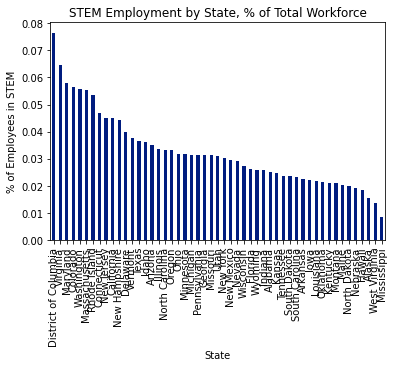

In [76]:
pd.crosstab(
    df['State'],
    df['stem_binary']
    ,normalize='index'
).sort_values(by=1,ascending=False)[1].plot(
    kind='bar'
    ,title='STEM Employment by State, % of Total Workforce'
)
plt.ylabel('% of Employees in STEM')

It seems like there's a significant difference between the District of Columbia, where 8% of the population has a STEM career, while Mississipi has close to zero.

<a id='Sex'></a>
#### 2b. Change Sex to 0/1
[Home](#home)<br><br>
In order for modeling to work moving forward, all binary values must be grounded to a zero/one format.

In [77]:
#from 1,2 to 0,1 (male,female)
df['SEX'] = df['SEX'] - 1
df['SEX'].unique()

array([0, 1], dtype=int64)

**Are there meaningful differences in STEM career attainment by Sex?**<br>

Text(0, 0.5, '% of Employees in STEM')

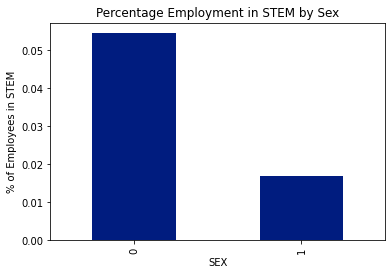

In [78]:
pd.crosstab(
    df['SEX'],
    df['stem_binary'],
    normalize='index'
).sort_values(by=1,ascending=False)[1].plot(
    kind='bar'
    ,title='Percentage Employment in STEM by Sex'
)
plt.ylabel('% of Employees in STEM')

At a cursory glance, Men (sex=0) tend to be employed in STEM roles twice as often as women.

<a id='Race'></a>
#### 2c. Defining under-represented racial groups
[Home](#home)<br><br>
Based on HigherME's subject matter experise, we consider under-represented groups to be non-white and non-asian. We will include hispanic individuals of any category in this group.

In [132]:
#for visualization, create a dictionary obj where each RACE code corresponds to its 
#string reperesentation. viewable in data_description directory.
race_map ={
    1: "White"
    ,2: "Black/African American"
    ,3: "American Indian or Alaska Native"
    ,4: "Chinese"
    ,5: "Japanese"
    ,6: "Other Asian or Pacific Islander"
    ,7: "Other race, nec"
    ,8: "Two major races"
    ,9: "Three or more major races"
}
df['RACE'].apply(lambda x: race_map[x]).value_counts()

White                               149702
Black/African American               18795
Other Asian or Pacific Islander       7644
Other race, nec                       7137
Two major races                       5731
Chinese                               2824
American Indian or Alaska Native      1999
Three or more major races              598
Japanese                               569
Name: RACE, dtype: int64

Based on the definition, however, we are primarily interested in exploring career differences between non-white/asian individuals and their counterparts based on documentation that can be accessed <a href="https://github.com/kayfilipp/HigherME/blob/main/README.md">here</a>. To this end, we can re-map the race for each row to exclude indices 1, 4, and 5. We do not exclude pacific islanders as of now, but are open to doing so if requirements change. We also include any hispanic individuals in our definition of under represented.

In [133]:
non_target = [1,4,5,6] #not white, asian

def under_rep_id(race,hispan):
    #if target is not 'Non-Hispanic'...
    if hispan != 0:
        return 1
    #and target isn't nonwhite/ nonasian...
    if race not in non_target:
        return 1
    #then they're not under-represented.
    return 0

#map racial status
df['under_represented'] = df.apply(lambda x: under_rep_id(x.RACE,x.HISPAN),axis=1)
df[['RACE','under_represented']].sample(10)

,RACE,under_represented
155492,2,1
19968,1,0
140802,1,1
67912,1,0
57073,1,0
100311,1,0
55169,1,1
99283,1,0
168645,6,0
75557,1,0


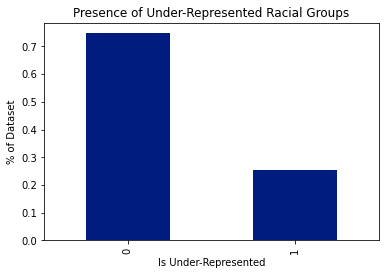

In [134]:
df['under_represented'].value_counts(normalize=True).plot(
    kind='bar', 
    title='Presence of Under-Represented Racial Groups'
)
plt.xlabel('Is Under-Represented')
plt.ylabel('% of Dataset')
plt.show()

#### Since we're not doing low level analysis that explores the differences between Black and Hispanic applicants, we can drop the nuance on hispanic data for now.

In [82]:
df = df.drop(['HISPAN','HISPAND'],axis=1)

<a id='bpl'></a>
#### 2d. Breakdown by Birthplace, EDA
[Home](#home)<br><br>

##### Furthermore, we can divide the birthplace feature (BPL) into a more low-resolution field - foreign born and domestic born individuals (ie those who are born in the continental US):

In [83]:
def is_domestic(bpl):
    #if birthplace code is for the US... (<100 = US states/territories)
    if bpl < 100:
        return 1
    return 0

df['domestic_born'] = df['BPL'].map(is_domestic)
df[['BPL','domestic_born']].head()

,BPL,domestic_born
0,27,1
1,36,1
2,200,0
3,27,1
4,39,1


Putting all this together, we can conclude that individuals that are born abroad and move to the US tend to be under-represented, while, as intiuition dictates, individuals born in the US tend to not be underrepresented. 

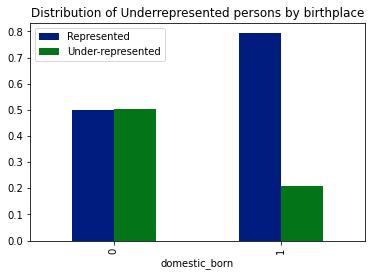

In [84]:
pd.crosstab(
    df['domestic_born'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by birthplace'
)
plt.legend(['Represented','Under-represented'])

**Is there a meaningful difference in STEM Employment between domestic and foreign-born persons?**

Text(0, 0.5, '% of Employees in STEM')

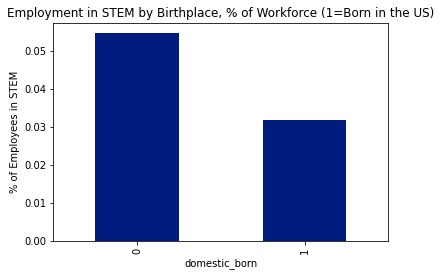

In [85]:
pd.crosstab(
    df['domestic_born'],
    df['stem_binary'],
    normalize='index'
).sort_values(by=1,ascending=False)[1].plot(
    kind='bar'
    ,title='Employment in STEM by Birthplace, % of Workforce (1=Born in the US)'
)
plt.ylabel('% of Employees in STEM')

Individuals born in the United States are somewhat less often employed in STEM. However, to determine if this difference is meaningful for analysis, we should conduct a hypothesis test.

In [86]:
fb = df[df['domestic_born']==1]
db = df[df['domestic_born']==0]

#Hypothesis testing: N1,N2
fb_n = len(fb)
db_n = len(db)
#hypothesis testing: X1,X2 
fb_x = len(fb[fb['stem_binary']==1])
db_x = len(db[db['stem_binary']==1])

In [87]:
significance = 0.025
# check our sample against Ho for Ha != Ho
successes = np.array([fb_x, db_x])
samples = np.array([fb_n, db_n])
# note, no need for a Ho value here - it's derived from the other parameters
stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
# report
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))
if p_value > significance:
    print("Fail to reject the null hypothesis - we have nothing else to say")
else:
    print("Reject the null hypothesis - suggest the alternative hypothesis is true")

z_stat: -19.780, p_value: 0.000
Reject the null hypothesis - suggest the alternative hypothesis is true


In conclusion, we can assert that birthplace is a relevant factor in determining STEM occupation.

<a id='EDU'></a>
#### 2e. Educational Attainment, EDA
[Home](#home)<br><br>

**Context:** The ``EDUC`` field contains values from 0-11 representing levels of educational attainment in increasing order - that is, a 0 is lower than a 1, etc. The `EDUCD` field extrapolates on the low-level details in a similar fashion. Our primary motivation is to simplify these values broadly into the following categories:

<ul>
    <li>None/Below Secondary (High School)</li>
    <li>Secondary (High School)</li>
    <li>Associate's</li>
    <li>Bachelor's</li>
    <li>Master's</li>
    <li>PhD/Other</li>
</ul>

In [88]:
def highest_edu(educd):
    if educd in [81,82,83]:
        return 'Associate'
    if educd == 101:
        return 'Bachelor'
    if educd in [114,115]:
        return 'Master'
    if educd in [116]:
        return 'PhD'
    if educd < 62 or educd==999:
        return 'None/Below HS'
    if educd < 114:
        return 'High School'
    
df['EDU_verbose'] = df['EDUCD'].map(highest_edu)
df[['EDU_verbose','EDUCD']].tail()

,EDU_verbose,EDUCD
194994,Bachelor,101
194995,Master,114
194996,High School,71
194997,High School,71
194998,Bachelor,101


Text(0, 0.5, '% of all education')

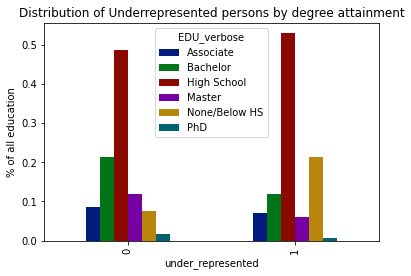

In [89]:
pd.crosstab(
    df['under_represented'],
    df['EDU_verbose'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by degree attainment'
)
plt.ylabel('% of all education')

major takeaways here include the fact that under-represented persons tend to drop out of high school at a far greater rate while earning fewer high school diplomas, master's degrees, associate's degrees, and bachelor's degrees.

<a id='empEDU'></a>
### 3. Employment & Education, EDA

[Home](#home)<br><br>
we first observe the difference in employment status across represented and underepresented groups and find that most of the populartion is employed in both groups, but under-represented communities tend to be more unemployed.

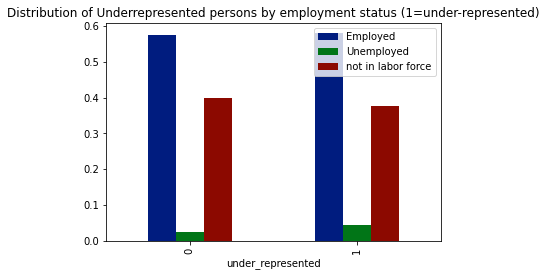

In [90]:
pd.crosstab(
    df['under_represented'],
    df['EMPSTAT'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by employment status (1=under-represented)'
)
plt.legend(['Employed','Unemployed','not in labor force'])

<a id='STEMEDU'></a>
#### 3b. Analyzing STEM Education in Particular
[Home](#home)<br><br>
In order to identify if a degree belong to a stem field, we have two tiers of analysis - one at the `DEGFIELD` level, which shows us a high-level description of the degree in question. If we do not confirm at this level that a field of study is STEM, we move into the `DEGFIELDD` field, which offers more specific information on the degree.

**for this section, we have developed a separate library containing logic that separates both DEGFIELD and DEGFIELDD codes into stem designation.**

In [91]:
#check deree_codes.py for more detail.
#looks at both the general degree area and specific major against a whitelist to see if a degree is 
#STEM related.
df['is_STEM_degree'] = df.apply(lambda x: dc.is_stem_degree(x.DEGFIELD,x.DEGFIELDD),axis=1)

In [92]:
df[['DEGFIELD','DEGFIELDD','is_STEM_degree']].head()

,DEGFIELD,DEGFIELDD,is_STEM_degree
0,0,0,0
1,0,0,0
2,53,5301,0
3,0,0,0
4,0,0,0


**Is there a meaningful difference in STEM Employment between STEM and non-STEM degrees?**

Text(0, 0.5, '% of Employees in STEM')

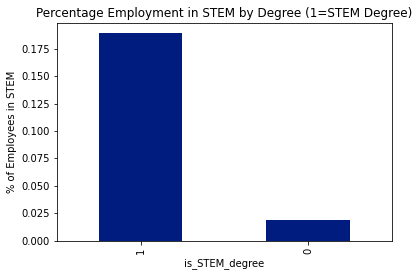

In [93]:
pd.crosstab(
    df['is_STEM_degree'],
    df['stem_binary'],
    normalize='index'
).sort_values(by=1,ascending=False)[1].plot(
    kind='bar'
    ,title='Percentage Employment in STEM by Degree (1=STEM Degree)'
)
plt.ylabel('% of Employees in STEM')

This was a relatively foregone conclusion, but still a necessary sanity check to proceed with modeling.

<a id='STEMRACE'></a>
#### 3c. STEM Degree Attainment by Racial Demographic
[Home](#home)<br><br>
A cursory analysis suggests that underrepresented individuals in STEM majors tend to have a significantly lower presence than in non-STEM fields.

<AxesSubplot:title={'center':'Distribution of Underrepresented persons by STEM attainment'}, xlabel='is_STEM_degree'>

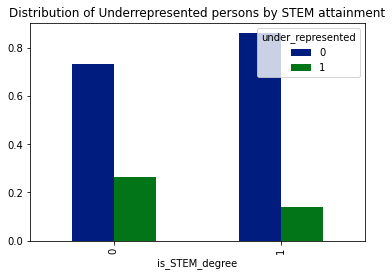

In [94]:
pd.crosstab(
    df['is_STEM_degree'],
    df['under_represented'],
    normalize='index'
).plot.bar(
    title='Distribution of Underrepresented persons by STEM attainment'
)

In [95]:
pd.crosstab(
    df['is_STEM_degree'],
    df['under_represented'],
    normalize='index'
)

under_represented,0,1
is_STEM_degree,,
0,0.734984,0.265016
1,0.861991,0.138009


On average, only ~14% of under-represented groups get a STEM degree compared to 27% of their counterparts, almost half as many.

<a id='STEMREP'></a>
#### 3d. Which STEM majors have the smallest under-represented group?
[Home](#home)<br><br>

Preliminary findings suggest that under-represented groups are least present in military technologies, Environmental Sciences, Math, and Physical Sciences.

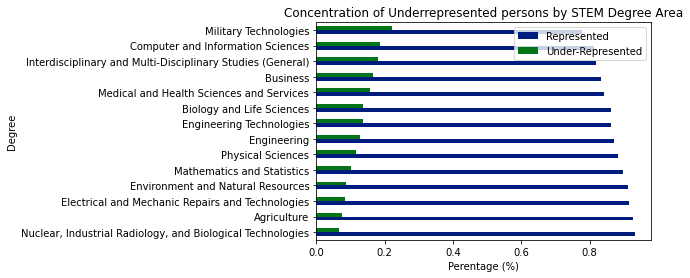

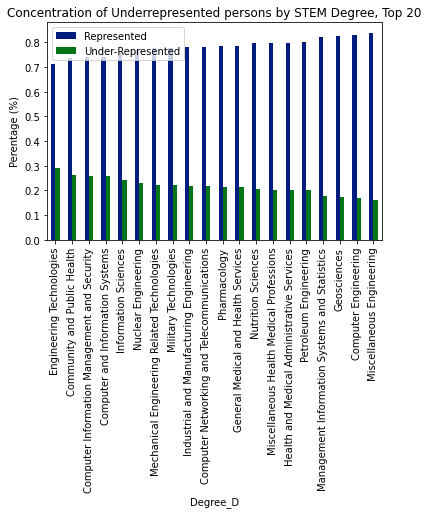

In [96]:
#string representations of degree codes 
df['Degree'] = df['DEGFIELD'].apply(lambda x: dc.degree_codes[x])
df['Degree_D']=df['DEGFIELDD'].apply(lambda x: dc.detail_codes[x])

temp = df.query("is_STEM_degree==1")

pd.crosstab(
    temp['Degree'],
    temp['under_represented'],
    normalize='index'
).sort_values(1).plot.barh(
    title='Concentration of Underrepresented persons by STEM Degree Area'
)
plt.xlabel('Perentage (%)')
plt.legend(['Represented','Under-Represented'])

pd.crosstab(
    temp['Degree_D'],
    temp['under_represented'],
    normalize='index'
).sort_values(0)[:20].plot.bar(
    title='Concentration of Underrepresented persons by STEM Degree, Top 20'
)
plt.ylabel('Perentage (%)')
plt.legend(['Represented','Under-Represented'])
del temp

However, we also note considerably racial parity in Computer Engineering, Electrical Engineering Technology and Computer Engineering - beyond these, in sorter order, racial parity begins to decrease quickly.

**Is there a meaningful difference in STEM Employment across STEM Degree Areas?**

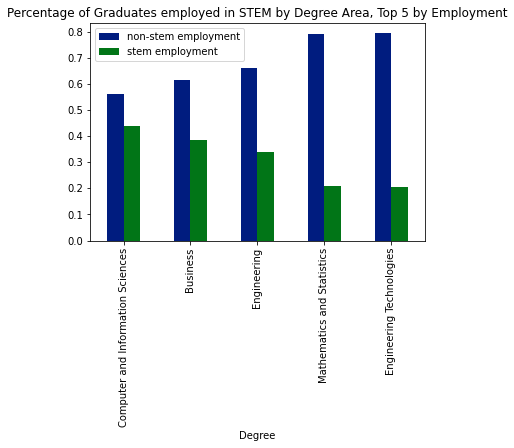

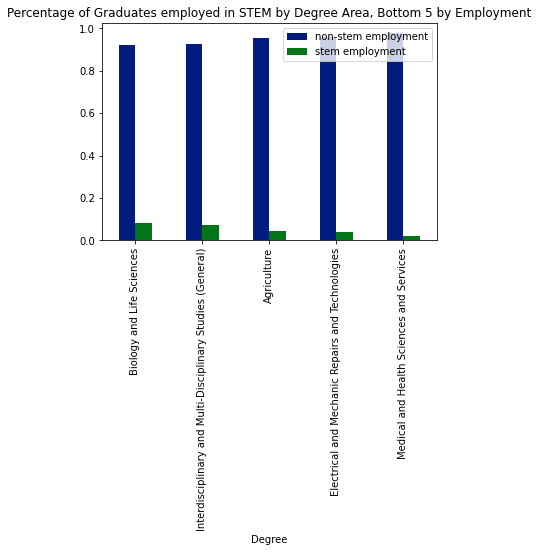

In [97]:
temp = df.query("is_STEM_degree==1")
pd.crosstab(
    temp['Degree'],
    temp['stem_binary'],
    normalize='index'
).sort_values(by=1,ascending=False)[0:5].plot.bar(
    title='Percentage of Graduates employed in STEM by Degree Area, Top 5 by Employment'
)

plt.legend(['non-stem employment','stem employment'])
pd.crosstab(
    temp['Degree'],
    temp['stem_binary'],
    normalize='index'
).sort_values(by=1,ascending=False)[-5:].plot.bar(
    title='Percentage of Graduates employed in STEM by Degree Area, Bottom 5 by Employment'
)
plt.legend(['non-stem employment','stem employment'])
del temp

Given that there seems to be considerable gaps in employment by STEM degree area, we may consider making `STEM_Degree_Area` a field for modeling where the value only exists if the individual has a STEM degree:

In [98]:
#essentially just DEGREE but for a provided 'NONE' option if a person did not get a STEM degree.
#will be used in modeling.
def stem_deg_area(is_stem_deg,deg):
    if is_stem_deg == 1:
        return deg 
    else:
        return 'None'

df['STEM_degree_area'] = df.apply(lambda x: stem_deg_area(x.is_STEM_degree,x.Degree),axis=1)

In [99]:
pd.DataFrame(df['STEM_degree_area'].unique())

,0
0,None
1,Engineering
2,Medical and Health Sciences and Services
3,Environment and Natural Resources
4,Biology and Life Sciences
5,Interdisciplinary and Multi-Disciplinary Studies (General)
6,Computer and Information Sciences
7,Physical Sciences
8,Mathematics and Statistics
9,Business


<a id='RACECAREER'></a>
### 4. Analyzing Career Attainment by Race, EDA
[Home](#home)<br><br>

#### What Roles do STEM majors tend to go into? 
We omit any indivudals with an `EmpStatus` that isn't 1 to get a clearer insight on employed STEM individuals. This visual displays both stem and non-stem careers.

<AxesSubplot:title={'center':'Top 20 Occupations for STEM majors'}>

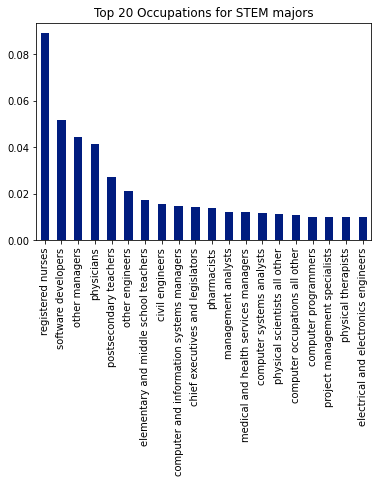

In [100]:
temp = df.query("is_STEM_degree==1 & EMPSTAT==1")
(temp['job_role'].value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]).plot(kind='bar',title='Top 20 Occupations for STEM majors')

The majority of individuals with STEM Degrees tend to go into nursing, medicine, software development, and engineering.

<a id='RACEROLES'></a>
#### 4b. What roles do under-represented STEM majors go into compared to their counterparts?
[Home](#home)<br><br>

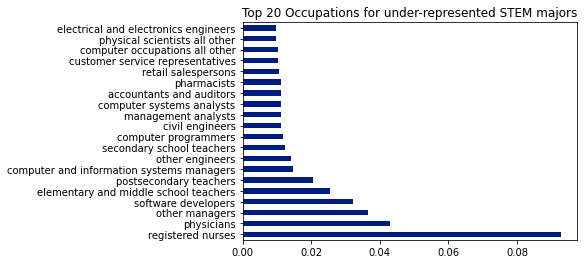

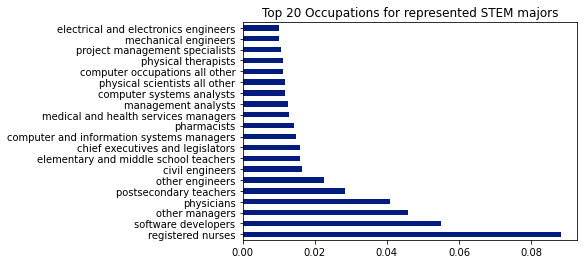

In [101]:
#get top 20 occupations for racial minority groups that got a STEM degree
df.query("is_STEM_degree==1 & EMPSTAT==1 & under_represented==1")['job_role']\
 .value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]\
.plot(kind='barh',title='Top 20 Occupations for under-represented STEM majors')
plt.show()

#get top 20 occupations for STEM graduates not from a minority racial group 
df.query("is_STEM_degree==1 & EMPSTAT==1 & under_represented==0")['job_role']\
 .value_counts(normalize=True).sort_values(
    ascending=False
)[0:20]\
.plot(kind='barh',title='Top 20 Occupations for represented STEM majors')
plt.show()

We can see that many STEM majors tend to go into nursing, leadership roles, but primarily into analyst and engineering roles, which lines up with expectations. Next, we can explore this breakdown by racial representation:

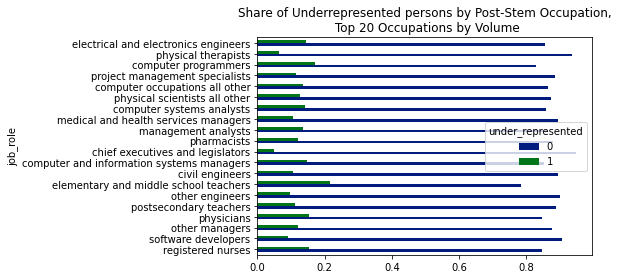

In [102]:
job_by_rep = pd.crosstab(
    temp['job_role']
    ,temp['under_represented']
)

#add another column for total employment and sort to get top 20 roles
job_by_rep[2] = job_by_rep[0]+job_by_rep[1]
job_by_rep[0] = job_by_rep[0] / job_by_rep[2]
job_by_rep[1] = 1 - job_by_rep[0]
job_by_rep    = job_by_rep.sort_values(2,ascending=False)[:20]
#get rid of total field to make chart clearer.
job_by_rep    = job_by_rep.drop(2,axis=1)
ax=job_by_rep.plot.barh(
    title=f'Share of Underrepresented persons by Post-Stem Occupation,\n Top {len(job_by_rep)} Occupations by Volume'
)

<a id='STEMP'></a>
#### 4c. What Portion of people work in a STEM field?
[Home](#home)<br><br>

While over 4% of represented individuals go into STEM, only 2% of unrepresented groups tend to go into the same fields - again, more than half as often.

In [103]:
df.groupby('under_represented')['stem_binary'].value_counts(normalize=True)

under_represented  stem_binary
0                  0              0.959856
                   1              0.040144
1                  0              0.979625
                   1              0.020375
Name: stem_binary, dtype: float64

this can better be understood by removing absent STEM-types from the chart:

In [104]:
df[df['stem_type']!=-1].groupby('under_represented')['stem_type'].value_counts(normalize=True)

under_represented  stem_type                                                                      
0                  Research, Development, Design, and Practitioners                                   0.598120
                   Other                                                                              0.155214
                   Managerial                                                                         0.110598
                   Research, Development, Design, and Practitioners; Technologists and Technicians    0.082564
                   Technologists and Technicians                                                      0.047692
                   Sales                                                                              0.005812
1                  Research, Development, Design, and Practitioners                                   0.529880
                   Other                                                                              0.140438
             

We observe relatively similar patterns of employment within racial groups, regardless of their frequency of entering a STEM field.

<a id='POST_SECOND'></a>
#### 4d. What portion of STEM Employees have a post-secondary education?
[Home](#home)<br><br>
Results show a slightly larger number of STEM employees with no college education for under-represented groups. In particular, under-represented groups have no STEM background 16% of the time while their counterparts only have a non-STEM background 8% of the time.

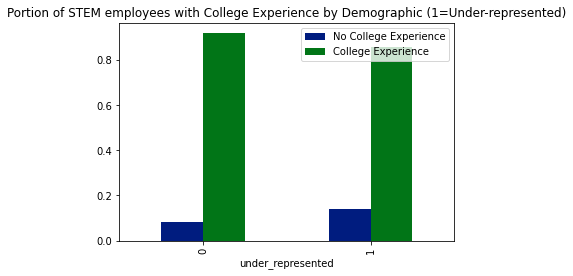

In [105]:
stem_employees = df[df['stem_type']!=-1]
stem_employees['past_HS'] = stem_employees['EDUC'] >= 7

pd.crosstab(
    stem_employees['under_represented'],
    stem_employees['past_HS'],
    normalize='index'
).plot(kind='bar',title='Portion of STEM employees with College Experience by Demographic (1=Under-represented)')
plt.legend(['No College Experience','College Experience'])

<a id='NONCOMPLETION'></a>
#### 4e. How do rates of college non-completion affect wages in a given profession?
[Home](#home)<br><br>

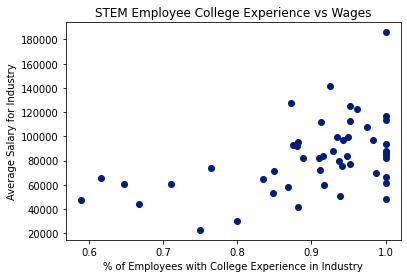

In [106]:
wage_hs = stem_employees.groupby('job_role')[['INCWAGE','past_HS']].mean()
plt.scatter(x=wage_hs['past_HS'],y=wage_hs['INCWAGE'])
plt.title ("STEM Employee College Experience vs Wages")
plt.xlabel("% of Employees with College Experience in Industry")
plt.ylabel("Average Salary for Industry")
plt.show()

<a id='RBD'></a>
#### 4f. Breaking Down STEM Role Areas By Demographic
[Home](#home)<br><br>

First, we examine what portion of each group is employed in STEM in general, then for individuals who hold a STEM degree. Analysis of the general population shows that across the board, under-represented individuals tend to be employed less frequently in STEM roles than in non-STEM roles.

<AxesSubplot:title={'center':'Concentration of Underrepresented persons by STEM Jobs'}, xlabel='stem_type'>

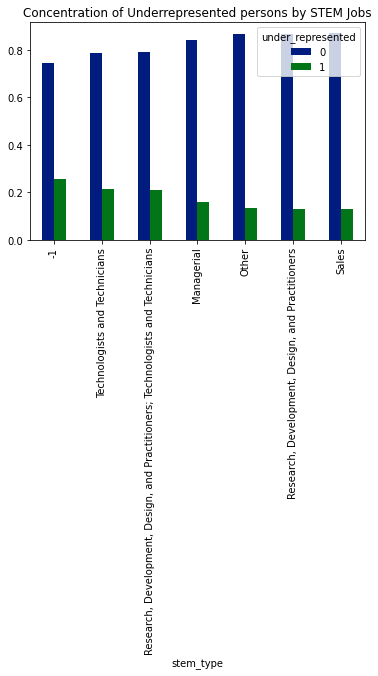

In [107]:
pd.crosstab(
    df['stem_type'],
    df['under_represented'],
    normalize='index'
).sort_values(0).plot.bar(
    title='Concentration of Underrepresented persons by STEM Jobs'
)

<a id='under_rep_stem_roles'></a>
#### 4g. What STEM roles do under-represented STEM graduates take on?
[Home](#home)<br><br>

<AxesSubplot:title={'center':'Concentration of Underrepresented STEM Graduates by STEM Job Areas'}>

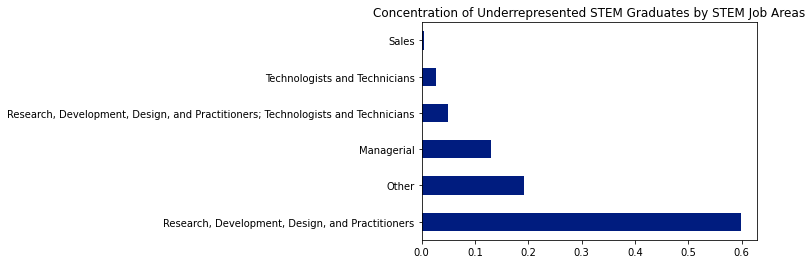

In [108]:
df[df['stem_type']!=-1].query("is_STEM_degree==1 & under_represented==1")['stem_type']\
.value_counts(normalize=True)\
.plot(kind='barh',title='Concentration of Underrepresented STEM Graduates by STEM Job Areas')

<AxesSubplot:title={'center':'Concentration of Underrepresented STEM Graduates by STEM Jobs, Top 10'}>

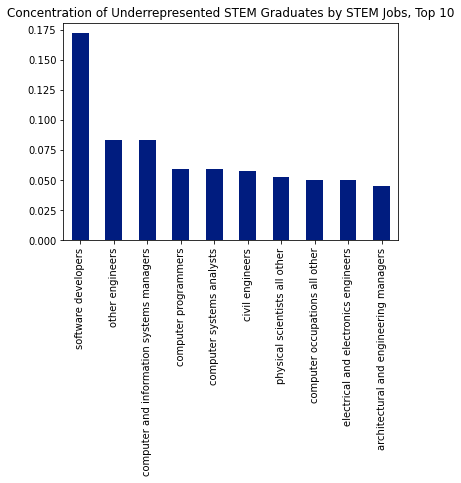

In [109]:
df[df['stem_type']!=-1].query("is_STEM_degree==1 & under_represented==1")['job_role'].value_counts(normalize=True)[0:10].plot(kind='bar',title='Concentration of Underrepresented STEM Graduates by STEM Jobs, Top 10')

STEM Graduates primarily tend to take on nursing and software developer roles - RNs, software evelopers, medical managers, computer occupations, and computer programs - which can all roughly be categorized as either medical or software development roles. 

<a id='salary'></a>
#### 4h. Salary Analysis - How Much Do Stem Employees Earn?
[Home](#home)<br><br>

<AxesSubplot:title={'center':'Median Wage by STEM Job Type'}, xlabel='stem_type'>

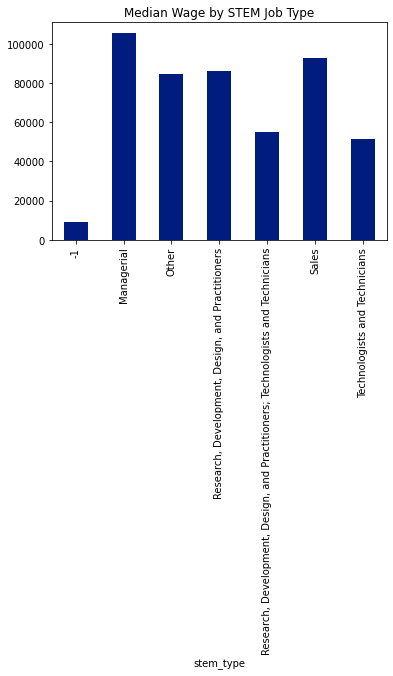

In [110]:
df.groupby('stem_type')['INCWAGE'].median().plot(kind='bar',title='Median Wage by STEM Job Type')

In [111]:
df[df['stem_type']!=-1].groupby(['under_represented','stem_type'])['INCWAGE'].median()

under_represented  stem_type                                                                      
0                  Managerial                                                                         106000.0
                   Other                                                                               84476.0
                   Research, Development, Design, and Practitioners                                    87620.0
                   Research, Development, Design, and Practitioners; Technologists and Technicians     58000.0
                   Sales                                                                               96387.0
                   Technologists and Technicians                                                       52798.0
1                  Managerial                                                                          90000.0
                   Other                                                                               80000.0
             

Underrepresented employees make considerably less in managerial and R&D/Practicioner roles than their counterparts. We can also extend this analysis to specific jobs, looking at the top 20 fields:

In [112]:
#get top 20 fields by volume of employees
top_twenty_fields = df[df['stem_type']!=-1]['job_role'].value_counts().sort_values(ascending=False)[:20]
top_twenty_fields = list(top_twenty_fields.index)
top_twenty_fields[:5]

['software developers',
 'computer occupations all other',
 'computer and information systems managers',
 'other engineers',
 'computer systems analysts']

In [113]:
top_twenty_workers = df[df['stem_type']!=-1].query(f"job_role in {top_twenty_fields}")

<AxesSubplot:title={'center':'Median Wage by STEM Role and Representation, Top 20 Fields'}, xlabel='job_role'>

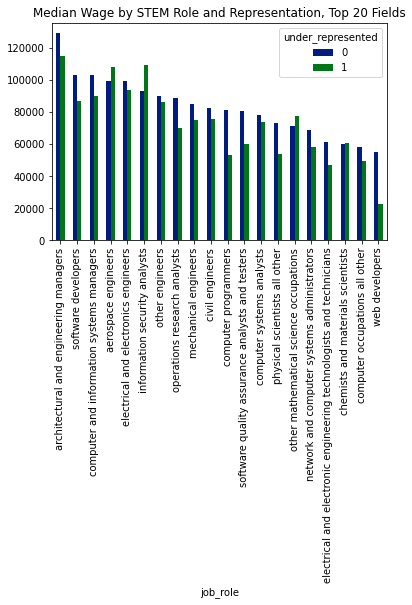

In [114]:
pd.crosstab(
    top_twenty_workers['job_role'],
    top_twenty_workers['under_represented'],
    values=top_twenty_workers['INCWAGE'],
    aggfunc = 'median'
).sort_values(0,ascending=False).plot(
    kind='bar',
    title='Median Wage by STEM Role and Representation, Top 20 Fields'
)

Although conclusively not relevant for our modeling, we have determined a significant wage discrepancy between represented and under-represented individuals in wages for most fields.

<a id='no_stem'></a>
#### 4i. In Total, What Portion of STEM Employees do not have a STEM Background?
[Home](#home)<br><br>

In [115]:
df[df['stem_type']!=-1]['is_STEM_degree'].value_counts(normalize=True)

1    0.521739
0    0.478261
Name: is_STEM_degree, dtype: float64

In [116]:
df[df['stem_type']!=-1].groupby('under_represented')['is_STEM_degree'].value_counts(normalize=True)

under_represented  is_STEM_degree
0                  1                 0.539829
                   0                 0.460171
1                  0                 0.583665
                   1                 0.416335
Name: is_STEM_degree, dtype: float64

In total, more than half of individuals working in a STEM field did not get a STEM education in both represented and under-represented groups. We can also look at the top fields for this trend:

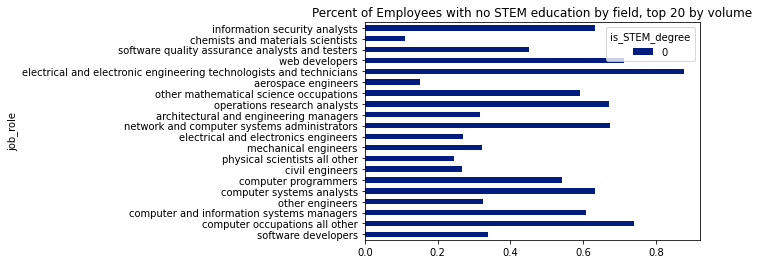

In [117]:
df_temp = df[df['stem_type']!=-1]
temp_cross = pd.crosstab(
    df_temp['job_role'],
    df_temp['is_STEM_degree'],
)

#we do not use normalize = True here because we want to get relative frequency
#but still want to sort by total volume 

temp_cross['n'] = temp_cross[0]+temp_cross[1]
temp_cross[0] = temp_cross[0]/temp_cross['n']
temp_cross[1] = temp_cross[1]/temp_cross['n']
temp_cross = temp_cross.sort_values(by='n',ascending=False)[:20]
temp_cross = temp_cross.drop(columns=['n',1])
temp_cross.plot(
    kind='barh',
    title='Percent of Employees with no STEM education by field, top 20 by volume'
)
#we can save this for the next cell.
top_stem_roles = list(temp_cross.index)

del df_temp
del temp_cross

<a id='no_stem_salary'></a>
#### 4j. How does not having a STEM degree affect income in these fields?
[Home](#home)<br><br>

In general, individuals who go into STEM roles tend to make considerably smaller median salaries, with the notable exception of web developers, web and digital interface designers, and mapping technicians, who have considerable parity.

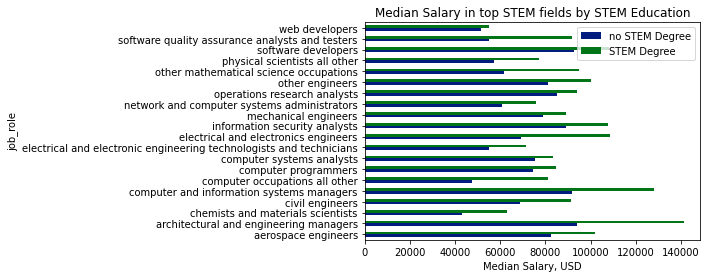

In [118]:
#get all individuals employed in the top stem roles by volume 
df_top_roles = df[df['job_role'].isin(top_stem_roles)]

#chart their median salaries by stem degree attainment
pd.crosstab(
    df_top_roles['job_role'],
    df_top_roles['is_STEM_degree'],
    values = df_top_roles['INCWAGE'],
    aggfunc = 'median'
).plot(kind='barh')
plt.title("Median Salary in top STEM fields by STEM Education")
plt.xlabel("Median Salary, USD")
plt.legend(['no STEM Degree','STEM Degree'])

<a id='publish'></a>
### 5. Publish Transformed Dataset 
[Home](#home)<br><br>
Having conducted the necesarry EDA and data transformation for our modeling step, we drop all irrelevant features and move our dataset into the `main_df.csv` destination. This data will be used by the `modeling.ipynb` notebook to select a suitable candidate model to deploy to streamlit for further testing.

In [119]:
df = df.drop(columns=[
    'RACE'
    ,'RACED'
    ,'BPL'
    ,'BPLD'
    ,'EDUC'
    ,'EDUCD'
    ,'DEGFIELD'
    ,'DEGFIELDD'
    ,'DEGFIELD2'
    ,'DEGFIELD2D'
    ,'EMPSTAT'
    ,'EMPSTATD'
    ,'OCC'
    ,'IND'
    ,'job_role'
    ,'Degree_D'
    ,'Degree'
    ,'INCWAGE'
])

In [120]:
df.head()

,SEX,AGE,stem_type,stem_binary,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,STEM_degree_area
0,0,53,-1,0,Wisconsin,0,1,High School,0,None
1,0,56,-1,0,New York,0,1,High School,0,None
2,1,35,-1,0,Pennsylvania,0,0,Bachelor,0,None
3,0,30,-1,0,Wisconsin,0,1,High School,0,None
4,0,47,-1,0,Ohio,0,1,High School,0,None


In [121]:
df.to_csv('./datasets/transformed/main_df.csv',index=None)